# Automatic Location Planning for Multiple mmWave Small Cells based on SNR Gradient Ascent with Adam Optimizer in 3D Ray Tracing Engine.

## Import libraries

In [1]:
import os, sys
sys.path.append('..')
from main import Env

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [3]:
import numpy as np
random_seed = 446655
np.random.seed(random_seed)

In [4]:
SCENE_PATH = os.path.join(os.getcwd(), "../obj/poznan.obj")

In [5]:
SCENE_IMG = os.path.join(os.getcwd(), "../obj/poz.png")

## Connect to the ray tracing engine
Connect to a ray tracing server

![](../obj/rt.gif)

In [6]:
env = Env('127.0.0.1', 8877) # connect to local ray tracer
env.reset() # reset

Server: Hello Client 


### Small Cell Variables

Set up for each small cell has transmitt power for 24 dBm with 28 GHz carrier frequency.

In [7]:
transmit_power = 24 # == 24 dBm
transmit_frequency = 28e9 # == 28 GHz
epsilon = 0.001 # small number for gradient calculation
cell_N = 4 # number of cell
user_N = 25 # numcer of users

### Hyperparameters

In [8]:
learning_rate = 5
beta_1 = 0.9
beta_2 = 0.99

![](../obj/mmWave.png)
the example how the ray tracing engine produce from 30 GHz mmWave.

### Scene Border

min and max border of the map

In [9]:
min_x = -143.236
max_x = 153.955
min_z = -140.049
max_z = 135.963

## Rules

### User SNR Evaluation
A user device will automatically connect to a station that provides the strongest power.

A user device, i, evaluates the quality by SNR( received power from connected cell over total receive from disconnected cells)
\begin{equation}
    SNR_{i}(x, y, z) = \frac{P_{rx, cell_{connected}}}{\sum{}P_{rx, cell_{disconnected}}}
\end{equation}



### Cell Evaluation
A cell evaluates how well its location is by averaging the SNR of the connected device to the cell.
\begin{equation}
    SNR_{avg} = \frac{1}{N} \sum_{i\rightarrow connected}^M SNR_i
\end{equation}


### The Gradient of Base Station Location
The gradient of the current location can be measured by observing the change of average path loss in small different positions.

\begin{equation}
\partial x = \frac{\partial SNR_{avg}}{\partial x_{cell}} = \frac{SNR_{avg}(x_{cell} + \epsilon , y_{cell}, z_{cell}) - SNR_{avg}(x_{cell} - \epsilon , y_{cell}, z_{cell})}{2\epsilon}
\end{equation}

\begin{equation}
\partial z = \frac{\partial SNR_{avg}}{\partial z_{cell}}  = \frac{SNR_{avg}(x_{cell}  , y_{cell}, z_{cell} + \epsilon) - SNR_{avg}(x_{cell} , y_{cell}, z_{cell} - \epsilon)}{2\epsilon}
\end{equation}

### Update the location
Then, the location can be updated by its current slope to the higher value as gradient ascent to the better location with lower loss.

\begin{equation}
x_{cell} := x_{cell} + \alpha * adam\_d x_{cell} 
\end{equation}
\begin{equation}
z_{cell} := z_{cell} + \alpha * adam\_d z_{cell} 
\end{equation}

## Adam Optimizer

optimizer for smoothing the gradients since the ray traced results are quite noisy.

In [10]:
class Adam:
    def __init__(self, beta_1, beta_2):
        self.b1 = beta_1
        self.b2 = beta_2
        self.v_dx, self.s_dx = 0,0 
        self.t = 0
    def grad(self, dx):
        self.t += 1
        self.v_dx = self.b1*self.v_dx + (1-self.b1)*dx # momentum
        self.s_dx = self.b2*self.s_dx + (1-self.b2)*np.power(dx,2) # RMS
        v_correct = self.v_dx/(1-np.power(self.b1,self.t))
        s_correct = self.s_dx/(1-np.power(self.b2,self.t))
        return v_correct/(np.sqrt(s_correct)+1e-8)

### Memory of User and Cells

In [11]:
Users = []
Cells = []

In [12]:
class User:
    def __init__(self):
        self.id = 0;
        self.status = {'cell_id':None, 'received_power': None, 'SNR':None}
        self.position = []
        self.generateUser()
        
    def calculate(self):
        max_rec_power_mW = 0
        max_cell_id = 0
        all_rec_power_wW = 0;

        # Calculate all possibile receive signal from cells
        for cell in Cells:
            env.com.connect_user_to_station(cell.id, self.id)
            info = env.com.ask_user_info(self.id)
            if info['result']['total_attenuation'] is None:
                continue
            env.com.disconnect_user_from_station(cell.id, self.id)
            rec_power_dBm = transmit_power + info['result']['total_attenuation'] # attenuation is minus
            rec_power_mW = np.power(10,rec_power_dBm/10)
            all_rec_power_wW += rec_power_mW
            if rec_power_mW > max_rec_power_mW:
                max_rec_power_mW = rec_power_mW
                max_cell_id = info['station']
                
        if max_rec_power_mW == 0:
            return # cannot find a station
        # Conclude the signal result
        self.status['cell_id'] = max_cell_id
        self.status['received_power'] =  10*np.log10(max_rec_power_mW)
        self.status['SNR'] = 10*np.log10( max_rec_power_mW/(all_rec_power_wW-max_rec_power_mW))
    
    def generateUser(self):
        position = [0, -10, 0]
        while env.com.is_outdoor(position) is False:
            x = np.random.uniform(min_x*2/3,max_x*2/3)
            z = np.random.uniform(min_z*2/3,max_z*2/3)
            y = np.random.uniform(1.5, 1.8)
            position = [x, y, z]
        env.com.add_user(position)
        self.id = env.com.ask_users_info()[-1]
        self.position = position


In [13]:
class Cell:
    def __init__(self):
        self.id = 0
        self.position = []
        self.generateCell()
        self.xOptimizer = Adam(beta_1, beta_2)
        self.zOptimizer = Adam(beta_1, beta_2)
        
    def move(self, position):
        self.position = position;
        env.com.move_station_to(self.id, position, [0.0, 0.0, 0.0])
        for user in Users:
            user.calculate()
        
    def generateCell(self):
        position = [0, -10, 0]
        while env.com.is_outdoor(position) is False:
            x = np.random.uniform(min_x/2,max_x/2)
            z = np.random.uniform(min_z/2,max_z/2)
            y = np.random.uniform(4, 8)
            position = [x, y, z]
        env.com.add_station(position, [0.0, 0.0, 0.0], transmit_frequency)
        self.id = env.com.ask_stations_info()[-1]
        self.position = position

    def countAvgConnectedSNR(self):
        avg_SNR = 0
        cnt_user = 0
        for user in Users:
            if user.status['cell_id'] == self.id:
                avg_SNR += user.status['SNR']
                cnt_user += 1
        if cnt_user == 0:
            return None
        return avg_SNR/cnt_user

    def getXZGradients(self):
        current_pos = self.position
        x_plus = [current_pos[0]+epsilon, current_pos[1], current_pos[2]]
        x_minus = [current_pos[0]-epsilon, current_pos[1], current_pos[2]]
        self.move(x_plus)
        SNR_x_plus = self.countAvgConnectedSNR()
        if SNR_x_plus is None:
            self.move(current_pos)
            return None, None
        self.move(x_minus)
        SNR_x_minus = self.countAvgConnectedSNR()
        if SNR_x_minus is None:
            self.move(current_pos)
            return None, None
        z_plus = [current_pos[0], current_pos[1], current_pos[2]+epsilon]
        z_minus = [current_pos[0], current_pos[1], current_pos[2]-epsilon]
        self.move(z_plus)
        SNR_z_plus = self.countAvgConnectedSNR()
        if SNR_z_plus is None:
            self.move(current_pos)
            return None, None
        self.move(z_minus)
        SNR_z_minus = self.countAvgConnectedSNR()
        if SNR_z_minus is None:
            self.move(current_pos)
            return None, None
        dx = (SNR_x_plus - SNR_x_minus)/(2*epsilon)
        dz = (SNR_z_plus - SNR_z_minus)/(2*epsilon)
        return dx, dz

In [14]:
def Display3D():
    ue_x_list,ue_y_list, ue_z_list = [],[],[]
    cell_x_list,cell_y_list, cell_z_list = [],[],[]
    
    for user in Users:
        position = user.position
        ue_x_list.append(position[0])
        ue_y_list.append(position[1])
        ue_z_list.append(position[2])
    
    for cell in Cells:
        position = cell.position
        cell_x_list.append(position[0])
        cell_y_list.append(position[1])
        cell_z_list.append(position[2])
        
    env.open(SCENE_PATH)
    env.visualise(ues = [ue_x_list,ue_y_list, ue_z_list], bss = [cell_x_list,cell_y_list,cell_z_list])

In [15]:
N_image = 0 # initialize for counting to generate images

In [16]:
def Display2D():
    global N_image
    user_x_list, user_z_list = [],[]
    cell_x_list, cell_z_list = [],[]
    for user in Users:
        position = user.position
        user_x_list.append(position[0])
        user_z_list.append(position[2]*-1) # flip axis
    
    for cell in Cells:
        position = cell.position
        cell_x_list.append(position[0])
        cell_z_list.append(position[2]*-1) # flip axis
    
    #fig, ax = plt.subplots()
    plt.figure()
    img = plt.imread(SCENE_IMG)
    plt.imshow(img, extent=[min_x, max_x, min_z, max_z])
    plt.scatter(user_x_list, user_z_list, c="blue")
    plt.scatter(cell_x_list, cell_z_list, c="red")
    plt.xlim(min_x, max_x)
    plt.ylim(min_z, max_z)
    plt.axis('off')
    plt.savefig('../obj/{0}-{1}-{2}-{3}_{4}.jpeg'.format( random_seed, learning_rate, cell_N, user_N, N_image))
    N_image = N_image+1
    plt.show()



## Simulation

### Randomly generate users

In [17]:
for i in range(user_N):
    Users.append(User())

### Randomly generate cells

In [18]:
for i in range(cell_N):
    Cells.append(Cell())

### Calculate User Connections

In [19]:
for user in Users:
    user.calculate()

### Check users and cells on map

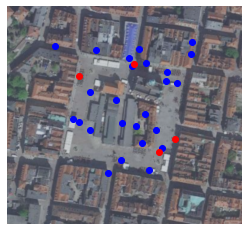

In [20]:
Display2D()

## Run Gradient Ascent

t:#0
#439:[-46.88587667231595, 6.985720736316706, -43.171535770903]
#440:[64.21035598409823, 6.596614433631358, 27.78951662197797]
#441:[44.472913849712704, 7.4947163658776255, 43.984929841680795]
#442:[22.567145886850007, 4.931137938947916, -57.97456686708662]


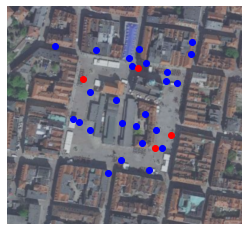

avg SNR: -16.92232330841709


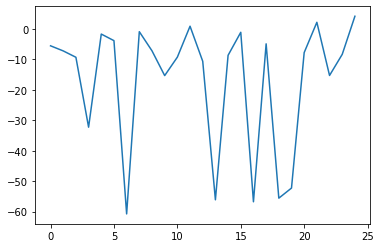

t:#1
#439:[-41.930169595499684, 6.985720736316706, -38.21170281001432]
#440:[59.555505843222804, 6.596614433631358, 22.78638048649196]
#441:[41.76714599968464, 7.4947163658776255, 42.124878496616105]
#442:[24.860865572954587, 4.931137938947916, -59.242491379916416]


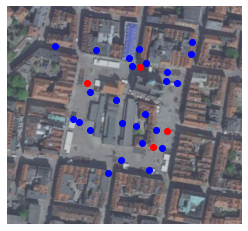

avg SNR: -16.11716796312452


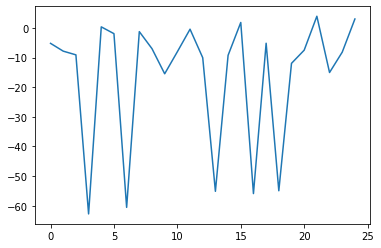

t:#2
#439:[-37.26359204068191, 6.985720736316706, -33.22740907107134]
#440:[54.74940560195113, 6.596614433631358, 17.82076041904552]
#441:[38.450089863831124, 7.4947163658776255, 42.40880312841513]
#442:[26.292747976633386, 4.931137938947916, -61.282558543342944]


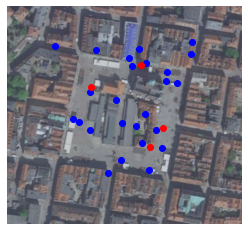

avg SNR: -16.084338039842116


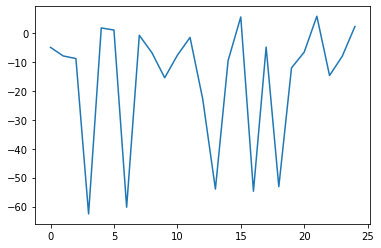

t:#3
#439:[-37.04151291580085, 6.985720736316706, -28.429515359399765]
#440:[49.88346540113889, 6.596614433631358, 14.21599449463761]
#441:[34.490003917403804, 7.4947163658776255, 43.5885790273503]
#442:[27.33397071568119, 4.931137938947916, -63.978937247511126]


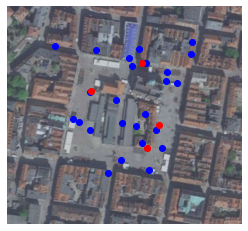

avg SNR: -14.007482187875805


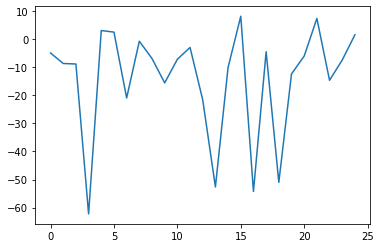

t:#4
#439:[-39.15095643255889, 6.985720736316706, -23.73111122465043]
#440:[46.54011863625846, 6.596614433631358, 16.18622616187411]
#441:[31.191483057970384, 7.4947163658776255, 41.82300989218264]
#442:[28.445751882109388, 4.931137938947916, -66.15928572347353]


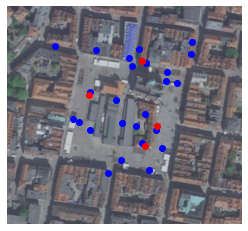

avg SNR: -11.982995795049208


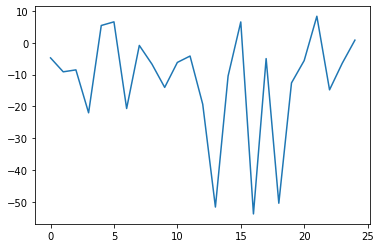

t:#5
#439:[-41.83776143876075, 6.985720736316706, -20.262498238334242]
#440:[45.23659566824456, 6.596614433631358, 18.426817475205286]
#441:[28.009406776474876, 7.4947163658776255, 39.1261183282952]
#442:[29.74654182086122, 4.931137938947916, -66.4464976415931]


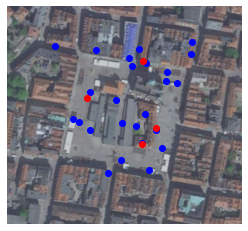

avg SNR: -11.426455794913165


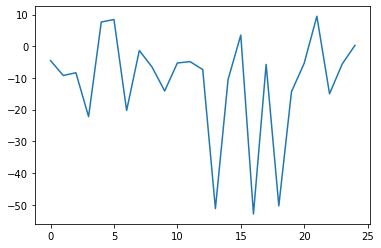

t:#6
#439:[-43.87207982381327, 6.985720736316706, -17.319456783623355]
#440:[45.27827603470133, 6.596614433631358, 20.92045081049306]
#441:[24.756349902253007, 7.4947163658776255, 41.62300742817316]
#442:[31.047908115561444, 4.931137938947916, -65.26737694168449]


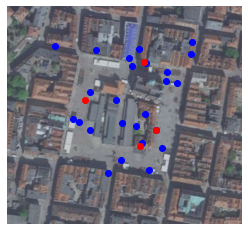

avg SNR: -11.783672827430173


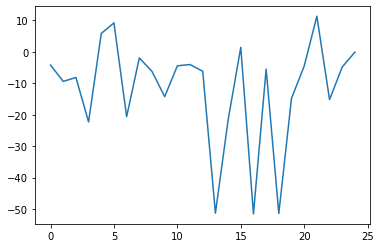

t:#7
#439:[-44.906688870669974, 6.985720736316706, -14.498367010557928]
#440:[45.44330419222539, 6.596614433631358, 22.818070799210133]
#441:[22.41078330705622, 7.4947163658776255, 43.829063907911966]
#442:[32.5971363208952, 4.931137938947916, -63.66089993765024]


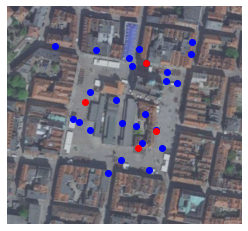

avg SNR: -13.356131888266935


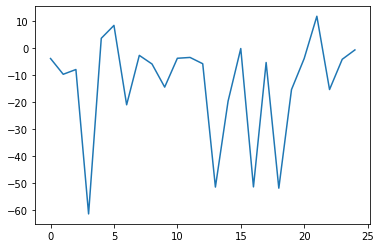

t:#8
#439:[-45.78518487153516, 6.985720736316706, -11.532184698195323]
#440:[45.300304022228296, 6.596614433631358, 25.217747824066013]
#441:[20.8900019730094, 7.4947163658776255, 45.79181748006289]


ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

In [21]:
total_SNR = []
for t in range(10):
    print('t:#' + str(t))
    for cell in Cells: 
        dx, dz = cell.getXZGradients()
        if dx is None or dz is None:
            continue # hit the wall, do nothing
        new_x = cell.position[0] + cell.xOptimizer.grad(dx)*learning_rate # gradient ascent
        new_z = cell.position[2] + cell.zOptimizer.grad(dz)*learning_rate # gradient ascent
        #new_x = cell.position[0] + dx*learning_rate # gradient ascent
        #new_z = cell.position[2] + dz*learning_rate # gradient ascent        
        new_position = [new_x, cell.position[1], new_z]
        print("#"+str(cell.id)+ ":" + str(new_position))
        cell.move(new_position)
    Display2D()
    # SNRs
    SNR_t = []
    for user in Users:
        SNR_t.append(user.status['SNR'])
    print('avg SNR: ' + str(np.sum(SNR_t)/len(SNR_t)))
    plt.figure()
    plt.plot(SNR_t)
    plt.show()
    total_SNR.append(SNR_t)

In [22]:
np.savez('../try{0}-{1}-{2}-{3}.npz'.format(random_seed, learning_rate, cell_N, user_N), x=np.array(total_SNR))

In [ ]:
env.disconnect()

## Result
As the result, the cell moved to optimize the SNR quality of its connected users. in which, in the same time, the cells are moving away from each other while trying to coverage its connected users.

![](../obj/SNR-gradient.gif)

## limitations
In this scenario, the mmWave small cell transmit frequency at 28 GHz, the receivers in NLOS could barely receive the signals from its nearest station, which cause the NLOS cells' SNR become negative since there are more multiple cells. However, this could be improved by install more number of cells in the scene to provide LOS path from small cells to every user.
Even SNR is negative, from the result, the small cells are still able to optimize its location since they needs to optimize its SNR. by total, the new optimized locations provide the better signal to users.